In [194]:
import neat
from neat import activations, Config, DefaultGenome
from neat.nn import FeedForwardNetwork

from numpy.testing import assert_almost_equal
import pickle

In [195]:
def add_node(g, config, new_node_id=None, bias=None, response=None, aggregation=None, activation=None):
    if new_node_id is None:
        new_node_id = config.get_new_node_key(g.nodes)
    ng = g.create_node(config, new_node_id)
    g.nodes[new_node_id] = ng
    if bias is not None:
        ng.bias = bias
    if response is not None:
        ng.response = response
    if aggregation is not None:
        ng.aggregation = aggregation
    if activation is not None:
        ng.activation = activation
    return new_node_id, ng

In [196]:
config_path = 'fixed_config'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
g = DefaultGenome(0)
g.configure_new(config.genome_config)
g.nodes.clear()
g.connections.clear()
# n0 = n1 - n2
# n1 = sigmoid(5*i1 - 0.5)
# n2 = sigmoid(5*i2 - 1.5)
add_node(g, config.genome_config, 0, 0.0, 1.0, 'sum', 'sigmoid')
add_node(g, config.genome_config, 1, -0.5, 5.0, 'sum', 'sigmoid')
add_node(g, config.genome_config, 2, -1.5, 5.0, 'sum', 'tanh')
g.add_connection(config.genome_config, -1, 1, 1.0, True)
g.add_connection(config.genome_config, -2, 2, 1.0, True)
g.add_connection(config.genome_config, 1, 0, 1.0, True)
g.add_connection(config.genome_config, 2, 0, -1.0, True)
net = FeedForwardNetwork.create(g, config)

v00 = net.activate([0.0, 0.0])
assert_almost_equal(v00[0], 0.075305, 1e-3)

v01 = net.activate([0.0, 1.0])
assert_almost_equal(v01[0], -0.924141, 1e-3)

v10 = net.activate([1.0, 0.0])
assert_almost_equal(v10[0], 0.999447, 1e-3)

v11 = net.activate([1.0, 1.0])
assert_almost_equal(v11[0], 2.494080e-8, 1e-3)

print(g)
with open(f'test_fixed.pkl', 'wb') as f:
    pickle.dump(g, f)

Key: 0
Fitness: None
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.5, response=5.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-1.5, response=5.0, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 2), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(-1, 1), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(1, 0), weight=1.0, enabled=True)
	DefaultConnectionGene(key=(2, 0), weight=-1.0, enabled=True)


In [197]:
from neat.graphs import feed_forward_layers
inputs = [0, 1]
outputs = [2]
connections = [(0, 2), (1, 2)]
layers = feed_forward_layers(inputs, outputs, connections)
assert [{2}] == layers, f"actually got: {layers}"
print(layers)

inputs = [0, 1]
outputs = [3]
connections = [(0, 2), (1, 2), (2, 3)]
layers = feed_forward_layers(inputs, outputs, connections)
assert [{2}, {3}] == layers, f"actually got: {layers}"
print(layers)


[{2}]
[{2}, {3}]


In [198]:
from numpy import exp
 
def sigmoid(x: float) -> float:
    return 1 / (1 + exp(-(x)))
 
def aggregation(inputs):
    out = 0
    for inpt in inputs:
        out += inpt
    return out
 
class FeedForwardNetwork(object):
    def __init__(self, inputs, outputs, node_evals):
        self.input_nodes = inputs
        self.output_nodes = outputs
        self.node_evals = node_evals
        self.values = dict((key, 0.0) for key in inputs + outputs)
 
    def activate(self, inputs):
        if len(self.input_nodes) != len(inputs):
            raise RuntimeError("Expected {0:n} inputs, got {1:n}".format(len(self.input_nodes), len(inputs)))
 
        for k, v in zip(self.input_nodes, inputs):
            self.values[k] = v
 
        for node, act_func, agg_func, bias, response, links in self.node_evals:
            node_inputs = []
            for i, w in links:
                node_inputs.append(self.values[i] * w)
            s = agg_func(node_inputs)
            self.values[node] = act_func(bias + response * s)
 
        return [self.values[i] for i in self.output_nodes]
 
inputs = [-1, -2, -3, -4]
outputs = [0, 1]
node_evals = [(2, sigmoid, aggregation, 0.0, 1.0, [(-2, 1), (-1, 1), (-3, 1), (-4, 1)]), (0, sigmoid, aggregation, 0.0, 1.0, [(2 ,1)]), (1, sigmoid, aggregation, 0.0, 1.0, [(2 ,1)])]
 
nn = FeedForwardNetwork(inputs, outputs, node_evals)
print(nn.activate([1, 0, 1, 0]))

[0.7069873680001046, 0.7069873680001046]


In [199]:
inputs = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13]
outputs = [0, 1]
node_evals = [(2, sigmoid, aggregation, 0.0, 1.0, [(-2, 1), (-1, 1), (-3, 1), (-4, 1)]), (0, sigmoid, aggregation, 0.0, 1.0, [(2 ,1)]), (1, sigmoid, aggregation, 0.0, 1.0, [(2 ,1)])]
 

In [200]:
def create_fully_connected_network(g, config, input_size, hidden_layers, output_size):
    next_input_node_id = -1  # Start for input nodes
    current_output_node_id = 0  # Start for output nodes
    next_hidden_node_id = output_size  # Hidden nodes start after output nodes

    node_layers = []

    # Helper function to add a layer of nodes
    def add_layer(layer_size, activation, layer_type):
        nonlocal next_input_node_id, current_output_node_id, next_hidden_node_id
        current_layer = []
        for _ in range(layer_size):
            if layer_type == 'input':
                node_id = next_input_node_id
                next_input_node_id -= 1
            elif layer_type == 'output':
                node_id = current_output_node_id
                current_output_node_id += 1
            else:  # 'hidden'
                node_id = next_hidden_node_id
                next_hidden_node_id += 1

            add_node(g, config.genome_config, new_node_id=node_id, bias=0.0, response=1.0, aggregation='sum', activation=activation)
            current_layer.append(node_id)
        return current_layer

    # Add output layer first to ensure output IDs are 0 to n-1
    node_layers.append(add_layer(output_size, activation='linear', layer_type='output'))

    # Add hidden layers
    for layer_size in hidden_layers:
        node_layers.insert(-1, add_layer(layer_size, activation='sigmoid', layer_type='hidden'))  # Insert before the output layer

    # Add input layer
    node_layers.insert(0, add_layer(input_size, activation='linear', layer_type='input'))  # Insert at the beginning

    # Connect the layers
    for i in range(len(node_layers)-1):
        for node_in in node_layers[i]:
            for node_out in node_layers[i+1]:
                g.add_connection(config.genome_config, input_key=node_in, output_key=node_out, weight=1.0, enabled=True)


In [201]:
config_path = 'config'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

g = DefaultGenome(0)
g.configure_new(config.genome_config)
g.nodes.clear()
g.connections.clear()

input_size = 13 # For example, 2 input nodes
hidden_layers = [20, 20]  # For example, 2 hidden layers with 3 and 2 neurons respectively
output_size = 4  # For example, 1 output node

create_fully_connected_network(g, config, input_size, hidden_layers, output_size)
#net = FeedForwardNetwork.create(g, config)

print(g)

Key: 0
Fitness: None
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=linear, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=linear, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=linear, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=linear, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	10 DefaultNodeGene(key=10, bias=0.0, response=1.0, activation=sigmoid, aggregation=sum)
	11 DefaultNodeGe

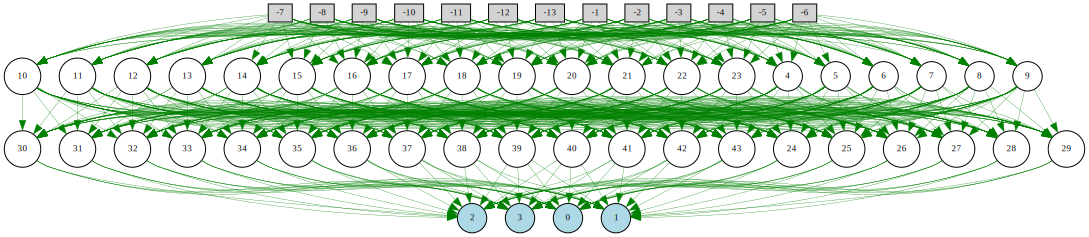

In [202]:
import visualize

visualize.draw_net(config, g, True)

In [10]:
import neat
from neat.genome import DefaultGenome
from neat.genes import DefaultNodeGene, DefaultConnectionGene
from neat.config import ConfigParameter, write_pretty_params
from neat.genes import BaseGene
from neat.attributes import FloatAttribute, BoolAttribute, StringAttribute
from neat.activations import ActivationFunctionSet
from itertools import count
from neat.aggregations import AggregationFunctionSet

class FixedStructureNodeGene(BaseGene):
    _gene_attributes = [
                        FloatAttribute('bias'),
                        FloatAttribute('response'),
                        StringAttribute('activation', options=''),
                        StringAttribute('aggregation', options='')]

    def distance(self, other, config):
        return 0.0


class FixedStructureConnectionGene(BaseGene):
    _gene_attributes = [FloatAttribute('weight')]

    def distance(self, other, config):
        d = abs(self.weight - other.weight) + abs(self.bias - other.bias)
        return d
    
class FixedStructureGenomeConfig(object):
    __params = [ConfigParameter('feed_forward', bool),
                ConfigParameter('num_inputs', int),
                ConfigParameter('num_outputs', int),
                ConfigParameter('num_hidden', int),
                ConfigParameter('num_hidden_layers', int),
                ConfigParameter('initial_connection', str, 'full_direct'),
                ConfigParameter('conn_add_prob', float),
                ConfigParameter('conn_delete_prob', float),
                ConfigParameter('node_add_prob', float),
                ConfigParameter('node_delete_prob', float)]


    def __init__(self, params):
        # Create full set of available activation functions.
        self.activation_defs = ActivationFunctionSet()
        self.activation_options = params.get('activation_options', 'sigmoid').strip().split()
        self.aggregation_options = params.get('aggregation_options', 'sum').strip().split()
        self.aggregation_function_defs = AggregationFunctionSet()

        # Gather configuration data from the gene classes.
        self.node_gene_type = params['node_gene_type']
        self.__params += self.node_gene_type.get_config_params()
        self.connection_gene_type = params['connection_gene_type']
        self.__params += self.connection_gene_type.get_config_params()
        self.connection_fraction = None
        self.node_indexer = None
        self.structural_mutation_surer = 'false'

        # Use the configuration data to interpret the supplied parameters.
        for p in self.__params:
            setattr(self, p.name, p.interpret(params))

        # By convention, input pins have negative keys, and the output
        # pins have keys 0,1,...
        self.input_keys = [-i - 1 for i in range(self.num_inputs)]
        self.output_keys = [i for i in range(self.num_outputs)]

    def get_new_node_key(self, node_dict):
        if self.node_indexer is None:
            if node_dict:
                self.node_indexer = count(max(list(node_dict)) + 1)
            else:
                self.node_indexer = count(max(list(node_dict)) + 1)

        new_id = next(self.node_indexer)

        assert new_id not in node_dict

        return new_id
    
    def save(self, f):
        write_pretty_params(f, self, self.__params)

class FixedStructureGenome(object):
    @classmethod
    def parse_config(cls, param_dict):
        param_dict['node_gene_type'] = FixedStructureNodeGene
        param_dict['connection_gene_type'] = FixedStructureConnectionGene
        return FixedStructureGenomeConfig(param_dict)
    
    @classmethod
    def write_config(cls, f, config):
        config.save(f)

    def __init__(self, key):
        self.key = key
        self.connections = {}
        self.nodes = {}

        # Fitness results.
        self.fitness = None

    def mutate(self, config):
        """ Mutates this genome. """
        # Mutate connection genes.
        for cg in self.connections.values():
            cg.mutate(config)

        # Mutate node genes (bias, response, etc.).
        for ng in self.nodes.values():
            ng.mutate(config)

    def configure_crossover(self, genome1, genome2, config):
        """ Configure a new genome by crossover from two parent genomes. """
        if genome1.fitness > genome2.fitness:
            parent1, parent2 = genome1, genome2
        else:
            parent1, parent2 = genome2, genome1

        # Inherit connection genes
        for key, cg1 in parent1.connections.items():
            cg2 = parent2.connections.get(key)
            if cg2 is None:
                # Excess or disjoint gene: copy from the fittest parent.
                self.connections[key] = cg1.copy()
            else:
                # Homologous gene: combine genes from both parents.
                self.connections[key] = cg1.crossover(cg2)
            self.connections[key].enabled = True

        # Inherit node genes
        parent1_set = parent1.nodes
        parent2_set = parent2.nodes

        for key, ng1 in parent1_set.items():
            ng2 = parent2_set.get(key)
            assert key not in self.nodes
            if ng2 is None:
                # Extra gene: copy from the fittest parent
                self.nodes[key] = ng1.copy()
            else:
                # Homologous gene: combine genes from both parents.
                self.nodes[key] = ng1.crossover(ng2)

    # def add_connection(self, config, input_key, output_key, weight):
    #     key = (input_key, output_key)
    #     connection = FixedStructureConnectionGene(key)
    #     connection.init_attributes(config)
    #     connection.weight = weight
    #     connection.enabled = True

    #     self.connections[key] = connection

    def distance(self, other, config):
        return 0.0
    
    def size(self):
        """Returns genome 'complexity', taken to be (number of nodes, number of enabled connections)"""
        num_enabled_connections = sum([1 for cg in self.connections.values() if cg.enabled is True])
        return len(self.nodes), num_enabled_connections

    def __str__(self):
        s = f"Key: {self.key}\nFitness: {self.fitness}\nNodes:"
        for k, ng in self.nodes.items():
            s += f"\n\t{k} {ng!s}"
        s += "\nConnections:"
        connections = list(self.connections.values())
        connections.sort()
        for c in connections:
            s += "\n\t" + str(c)
        return s
    
    # def add_hidden_nodes(self, config):
    #     for i in range(config.num_hidden):
    #         node_key = self.get_new_node_key()
    #         assert node_key not in self.nodes
    #         node = self.__class__.create_node(config, node_key)
    #         self.nodes[node_key] = node

    def compute_full_connections(self, config, direct):
        """
        Compute connections for a fully-connected feed-forward genome--each
        input connected to all hidden nodes
        (and output nodes if ``direct`` is set or there are no hidden nodes),
        each hidden node connected to all output nodes.
        (Recurrent genomes will also include node self-connections.)
        """
        hidden = [i for i in self.nodes if i not in config.output_keys]
        output = [i for i in self.nodes if i in config.output_keys]
        connections = []
        if hidden:
            for input_id in config.input_keys:
                for h in hidden:
                    connections.append((input_id, h))
            for h in hidden:
                for output_id in output:
                    connections.append((h, output_id))
        if direct or (not hidden):
            for input_id in config.input_keys:
                for output_id in output:
                    connections.append((input_id, output_id))
        return connections   

    def configure_new(self, config):
        # Create node genes for the input and output nodes
        for node_key in config.input_keys + config.output_keys:
            self.nodes[node_key] = self.create_node(config, node_key)

        # Initialize list to keep track of nodes in the last layer (start with input layer)
        last_layer_nodes = config.input_keys

        # Add hidden nodes and layers
        # config.num_hidden now represents the number of neurons PER HIDDEN LAYER
        if config.num_hidden > 0 and config.num_hidden_layers > 0:
            for _ in range(config.num_hidden_layers):
                layer_node_ids = []
                for _ in range(config.num_hidden):  # Create the specified number of nodes for this layer
                    node_key = config.get_new_node_key(self.nodes)
                    self.nodes[node_key] = self.create_node(config, node_key)
                    layer_node_ids.append(node_key)
                
                # Connect all nodes from the last layer to the current layer's nodes
                for last_layer_node in last_layer_nodes:
                    for current_layer_node in layer_node_ids:
                        connection = self.create_connection(config, last_layer_node, current_layer_node)
                        self.connections[connection.key] = connection

                # Update last_layer_nodes to reflect the current layer for next iteration
                last_layer_nodes = layer_node_ids

            # Connect all nodes from the last hidden layer to the output nodes
            for hidden_node_id in last_layer_nodes:
                for output_node_id in config.output_keys:
                    connection = self.create_connection(config, hidden_node_id, output_node_id)
                    self.connections[connection.key] = connection
        else:
            # If there are no hidden layers, connect input nodes directly to output nodes
            for input_node_id in config.input_keys:
                for output_node_id in config.output_keys:
                    connection = self.create_connection(config, input_node_id, output_node_id)
                    self.connections[connection.key] = connection

    @staticmethod
    def create_node(config, node_id):
        node = FixedStructureNodeGene(node_id)
        node.init_attributes(config)
        return node

    @staticmethod
    def create_connection(config, input_id, output_id):
        connection = config.connection_gene_type((input_id, output_id))
        connection.init_attributes(config)
        return connection
# Remember to adjust the class as needed for your application


In [7]:
import unittest

config_path = 'config_fixed'

config = neat.Config(FixedStructureGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        config_path)

pop = neat.Population(config)




In [8]:
class TestGenome(unittest.TestCase):
    def test_genome(self):
        gid = 42
        g = FixedStructureGenome(gid)
        self.assertEqual(gid, g.key)
        g.configure_new(config.genome_config)
        print(g)

In [11]:
g = FixedStructureGenome(42)
g.configure_new(config.genome_config)
print(g)
visualize.draw_net(config, g, True)

Key: 42
Fitness: None
Nodes:
	-1 FixedStructureNodeGene(key=-1, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-2 FixedStructureNodeGene(key=-2, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-3 FixedStructureNodeGene(key=-3, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-4 FixedStructureNodeGene(key=-4, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-5 FixedStructureNodeGene(key=-5, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-6 FixedStructureNodeGene(key=-6, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-7 FixedStructureNodeGene(key=-7, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-8 FixedStructureNodeGene(key=-8, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-9 FixedStructureNodeGene(key=-9, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-10 FixedStructureNodeGene(key=-10, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-11 FixedStructureNodeGene(key=-11, bi

NameError: name 'visualize' is not defined

In [1]:
config_path = 'config'
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

g2 = DefaultGenome(42)
g2.configure_new(config.genome_config)
print(g2)

NameError: name 'neat' is not defined

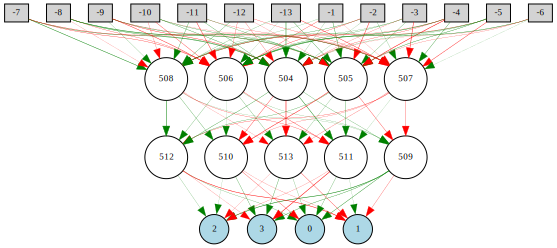

In [208]:

visualize.draw_net(config, g, True)

In [209]:
TestGenome().test_genome()

Key: 42
Fitness: None
Nodes:
	-1 FixedStructureNodeGene(key=-1, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-2 FixedStructureNodeGene(key=-2, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-3 FixedStructureNodeGene(key=-3, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-4 FixedStructureNodeGene(key=-4, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-5 FixedStructureNodeGene(key=-5, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-6 FixedStructureNodeGene(key=-6, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-7 FixedStructureNodeGene(key=-7, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-8 FixedStructureNodeGene(key=-8, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-9 FixedStructureNodeGene(key=-9, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-10 FixedStructureNodeGene(key=-10, bias=0.0, response=1.0, activation=tanh, aggregation=sum)
	-11 FixedStructureNodeGene(key=-11, bi